# 레이블을 CAGR로 잡았기 때문에 label cagr 합치기

In [ ]:
import pandas as pd

cagr = pd.read_csv('adj_adj_cagr.csv')
df = pd.read_csv('../../../python/해커톤/23104/cagr_merge.csv')


In [ ]:
cagr.drop(['2010_head', '2018_head', 'year_tail', 'CAGR_train', 'CAGR_test'], axis= 1, inplace= True)

In [ ]:
cagr['ticker']= cagr['ticker'].astype(str).str.zfill(6)

In [ ]:
cagr.rename(columns={'ticker':'거래소코드'}, inplace= True)

In [ ]:
cagr.rename(columns={'year':'연도'}, inplace= True)

In [ ]:
df.drop(['test_cagr(%)', 'train_cagr(%)'], axis=1, inplace= True)

In [ ]:
df['거래소코드']= df['거래소코드'].astype(str).str.zfill(6)

In [ ]:
data = pd.merge(df, cagr, on = ['거래소코드','연도'], how = 'left' )

In [ ]:
data.to_csv('adj_cagr_merge_data.csv', index= False, encoding= 'utf-8-sig')

In [ ]:
data = data.dropna().reset_index(drop= True)

In [ ]:
data = data.drop('자산총계', axis=1)
data['Buffett']= data['Buffett'].astype(str)

In [ ]:
data.columns

Index(['회사명', '거래소코드', '회계년도', 'ROE', 'ROIC', 'OPEX/매출', '잉여현금흐름', 'Buffett',
       'ROCE', '자사주매입1', '자사주매입2', '주주환원1', '주주환원2', '배당율', '보통주식비율', '연도',
       '평가사명 및 등급', '신용등급', '증권명', '부채비율', '당좌비율', '유동비율', '자기자본 비율', '재무레버리지',
       '신용스프레드', 'CAGR_tr(%)', 'CAGR'],
      dtype='object')

In [ ]:
import pandas as pd
data['부채비율']=data['부채비율']/100
data['CAGR_tr(%)']=data['CAGR_tr(%)']/10000
data['자기자본 비율']=data['자기자본 비율']/100
data.drop('증권명',axis=1,inplace=True)

## Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 특정 feature에 대한 통계 정보 계산하고 동시에 데이터 스케일링
data[['신용스프레드', '잉여현금흐름', 'Buffett','부채비율','유동비율']] = scaler.fit_transform(data[['신용스프레드', '잉여현금흐름', 'Buffett','부채비율','유동비율']])

In [ ]:
data.head(2)

,회사명,거래소코드,회계년도,ROE,ROIC,OPEX/매출,잉여현금흐름,Buffett,ROCE,자사주매입1,...,평가사명 및 등급,신용등급,부채비율,당좌비율,유동비율,자기자본 비율,재무레버리지,신용스프레드,CAGR_tr(%),CAGR
0,케이알모터스(주),000040,2010/12,-0.008024,-0.004607,0.099983,-0.049425,-0.096097,0.936112,-0.0,...,ubion,BBB-,-0.036249,0.364804,-0.374185,1.0,1.168625,0.920807,0.110019,0.134454
1,케이알모터스(주),000040,2011/12,0.028117,0.017462,0.101558,-0.068834,-0.093772,-0.254909,0.0,...,ubion,BBB-,-0.050679,0.236443,-0.286936,1.0,0.939045,0.820607,0.053557,0.057188


In [ ]:
data['재무레버리지'].describe

<bound method NDFrame.describe of 0       1.168625
1       0.939045
2       0.962711
3       1.040170
4       1.989406
          ...   
3466    0.817503
3467    1.082808
3468    0.805843
3469    0.528617
3470    0.620312
Name: 재무레버리지, Length: 3471, dtype: float64>

## Min-Max Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mn_scaler = MinMaxScaler()
data[['신용스프레드', '잉여현금흐름', 'Buffett','부채비율','유동비율','재무레버리지']] = mn_scaler.fit_transform(data[['신용스프레드', '잉여현금흐름', 'Buffett','부채비율','유동비율', '재무레버리지']])

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(data['신용등급'])
data['신용등급'] = encoder.transform(data['신용등급'])

print('인코딩 클래스:', encoder.classes_)

인코딩 클래스: ['A' 'A+' 'A-' 'AA' 'AA+' 'AA-' 'AAA' 'BBB' 'BBB+' 'BBB-']


In [ ]:
data['회계년도'] = pd.to_datetime(data['회계년도'])

# 17년, 22년 기준으로 CAGR크면 1로 처리.
data.loc[(data['회계년도'].dt.year == 2017) & (data['CAGR'] >= 0.113292), 'label'] = 1
data.loc[(data['회계년도'].dt.year == 2022) & (data['CAGR'] >= 0.07329), 'label'] = 1

In [ ]:
#트레인,테스트 데이터셋 분리
df_tr = pd.DataFrame()
df_test = pd.DataFrame()

# 인덱스를 기준으로 8개씩 묶어서 반복
for i in range(0, len(data), 13):
    # 트레인 데이터 추출
    train_batch = data.iloc[i:i+8]
    df_tr = pd.concat([df_tr, train_batch])

    # 테스트 데이터 추출
    test_batch = data.iloc[i+8:i+13]
    df_test = pd.concat([df_test, test_batch])

df_tr['label']=df_tr['label'].fillna(0)
df_test['label']=df_test['label'].fillna(0)

In [ ]:
existing_row = df_tr.loc[(df_tr['label'] == 1) & (df_tr['회계년도'].dt.year == 2017)]
code1=existing_row['거래소코드'].unique()

for i in code1:
    condition = df_tr['거래소코드'] == i
    df_tr.loc[condition, 'label'] = 1

#17년도 1이면 10~17 1로처리.

In [ ]:
existing_test = df_test.loc[(df_tr['label'] == 1) & (df_test['회계년도'].dt.year == 2022)]
code2=existing_test['거래소코드'].unique()

for i in code2:
    condition = df_tr['거래소코드'] == i
    df_tr.loc[condition, 'label'] = 1

#22년도 1이면 18~22 1로처리

In [ ]:
x_tr=df_tr.drop('label',axis=1)
y_tr=df_tr['label']
x_test=df_test.drop('label',axis=1)
y_test=df_test['label']

x_tr.drop(['회사명', '거래소코드', '주주환원1','주주환원2','자사주매입1','배당율','회계년도','평가사명 및 등급','CAGR','CAGR_tr(%)','연도', '자기자본 비율','부채비율', '유동비율','신용스프레드'],axis=1,inplace=True)
x_test.drop(['회사명', '거래소코드', '주주환원1','주주환원2','자사주매입1','배당율','회계년도','평가사명 및 등급','CAGR','CAGR_tr(%)','연도','자기자본 비율','부채비율','유동비율','신용스프레드'],axis=1,inplace=True)

## Feature Importance

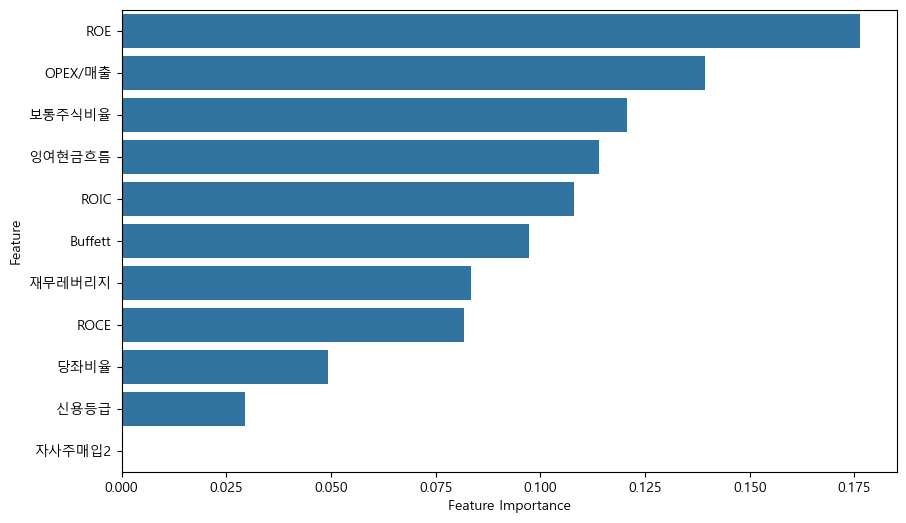

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Malgun Gothic'


# 예시 데이터 로드

X = x_tr
y = y_tr

# Random Forest 모델 생성
model = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=5)
model.fit(X, y)

# 변수 중요도 확인
feature_importances = model.feature_importances_

# 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

import seaborn as sns

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[indices], y=X.columns[indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## Feature Selection

## Wrapper

In [ ]:
## 1. Wrapper

# Forward Selection

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Forward feature selection 수행
selected_features = []
best_score = 0

while len(selected_features) < X.shape[1]: #무한 반복 루프 전체 특성의 개수보다 선택된 특성의 개수가 작을때 까지 반복
    best_feature = None #가장좋은 특성 이름
    best_model = None #가장좋은 모델 저장
    best_score_local = 0 #가장 높은 정확도

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_val[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_val)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nForward selected features:")
Forward = selected_features
print(Forward)

Selected feature: ROIC, Accuracy: 0.6472
Selected feature: 당좌비율, Accuracy: 0.6565
Selected feature: 잉여현금흐름, Accuracy: 0.6589

Forward selected features:
['ROIC', '당좌비율', '잉여현금흐름']


In [ ]:
# Backward Elimination
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# 경고창 제거
import warnings
warnings.filterwarnings('ignore')

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Backward feature selection 수행
selected_features = X_train.columns.tolist()
best_score = 0

while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_val[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_val)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nFinal selected features:")
Backward = selected_features
print(Backward)

Removed feature: OPEX/매출, Accuracy: 0.6799
Removed feature: ROE, Accuracy: 0.6822

Final selected features:
['ROIC', '잉여현금흐름', 'Buffett', 'ROCE', '자사주매입2', '보통주식비율', '신용등급', '당좌비율', '재무레버리지']


In [ ]:
# Stepwise Selection
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Stepwise feature selection 수행
selected_features = []
best_score = 0

# Forward step
while len(selected_features) < X.shape[1]:
    best_feature = None
    best_model = None
    best_score_local = 0

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_val[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_val)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

# Backward step
while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_val[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_val)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nFinal selected features:")
Stepwise = selected_features

Selected feature: ROIC, Accuracy: 0.6472
Selected feature: 당좌비율, Accuracy: 0.6565
Selected feature: 잉여현금흐름, Accuracy: 0.6589

Final selected features:


2. Filter

In [ ]:
# H가 1인 경우 이분산성 / H가 0인 경우 등분산
from scipy.stats import bartlett
def bartlett_test(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val =bartlett(data[data['label']==1][i], data[data['label']==0][i])
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [ ]:
# 이분산성 변수
x_hetero = bartlett_test(data.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test(data.columns, H = 0)


In [ ]:
# t_test

import scipy.stats as stats
def t_test(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(data[data['label']==1][i], data[data['label']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(data[data['label']==1][i], data[data['label']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [ ]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest = t_test(df.columns, x_homo, x_hetero, p_value=0.1)
print("유의한 피쳐 수 :", len(x_ttest))
x_ttest.sort_values(by="변수", ascending=True)

유의한 피쳐 수 : 0


,변수,p_value


3. Embedded

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.simplefilter('ignore')

lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'],
                'C' : [0.001, 0.01, 0.1, 1, 2, 5, 10],
                'solver' : ['liblinear']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)

df = pd.DataFrame(grid_search.cv_results_)
df = df.sort_values(by=['rank_test_score'], ascending=True)
df[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
GridSearchCV 최고 정확도:0.6557


In [ ]:
lasso_best = LogisticRegression(C=0.1, penalty='l1', solver='liblinear').fit(X_train, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso

,feature,coef
0,ROE,0.384711
1,ROIC,2.642697
2,OPEX/매출,1.227966
3,잉여현금흐름,2.699411
5,ROCE,0.007282
7,보통주식비율,0.016528
8,신용등급,0.044766
9,당좌비율,-0.298579


In [ ]:
## 보통주식비율, ROCE, 신용등급 삭제

In [ ]:
# 라쏘에서 선택된 피처
lasso = df_lasso['feature'].values.tolist()
print('Lasso에서 선택된 피처 수 {0:1.0f}'.format(len(df_lasso)), '개')
lasso

Lasso에서 선택된 피처 수 8 개


['ROE', 'ROIC', 'OPEX/매출', '잉여현금흐름', 'ROCE', '보통주식비율', '신용등급', '당좌비율']

In [ ]:
list_Forward = list(Forward)
list_Backward = list(Backward)
list_Stepwise = list(Stepwise)
list_lasso = list(lasso)
list_col_all = X_train.columns

In [ ]:
def func_Forward(x):
    if x in list_Forward:
        return 1
    else:
        return 0

def func_Backward(x):
    if x in list_Backward:
        return 1
    else:
        return 0


def func_Stepwise(x):
    if x in list_Stepwise:
        return 1
    else:
        return 0


def func_lasso(x):
    if x in list_lasso:
        return 1
    else:
        return 0

In [ ]:
# 2번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)

feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 6


,Feature,Forward,Backward,Stepwise,lasso,total
1,ROIC,1,1,1,1,4
3,잉여현금흐름,1,1,1,1,4
5,ROCE,0,1,0,1,2
7,보통주식비율,0,1,0,1,2
8,신용등급,0,1,0,1,2
9,당좌비율,1,1,1,1,4


In [ ]:
# 3번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)

feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=3]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 3


,Feature,Forward,Backward,Stepwise,lasso,total
1,ROIC,1,1,1,1,4
3,잉여현금흐름,1,1,1,1,4
9,당좌비율,1,1,1,1,4
